# Лабораторная работа №2

_Выполнили: Гуревич Михаил и Трохан Александр, M32001_

## Подготовка
Для начала зададим функцию, которую будем анализировать в процессе работы и построим её график.

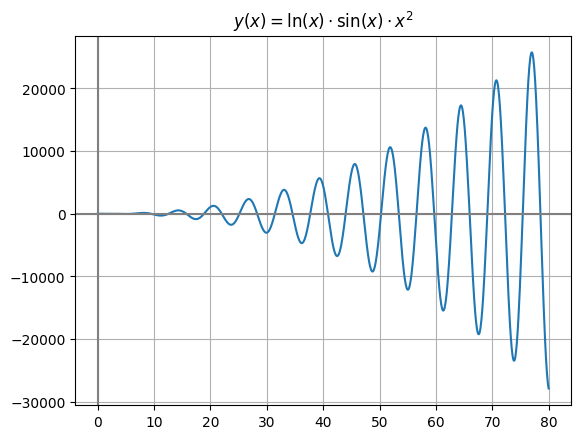

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from types import FunctionType


PHI = (1 + np.sqrt(5)) / 2  # Золотое сечение


def plot(func, left, right, title, x_axis=True, y_axis=True):
    x = np.linspace(left, right, 1000)
    y = func(x)
    plt.plot(x, y)
    plt.grid()
    if x_axis:
        plt.axhline(y=0, color="grey")
    if y_axis:
        plt.axvline(x=0, color="grey")
    plt.title(title)
    plt.show()


def func(x):
    return np.log(x) * np.sin(x) * np.power(x, 2)


plot(func, 0.0001, 80, "$y(x) = \ln(x) \cdot \sin(x) \cdot x^2$")

Для того, чтобы функция была унимодальной, будем рассматривать её на ограниченном отрезке, в нашем случае от 2.5 до 7.

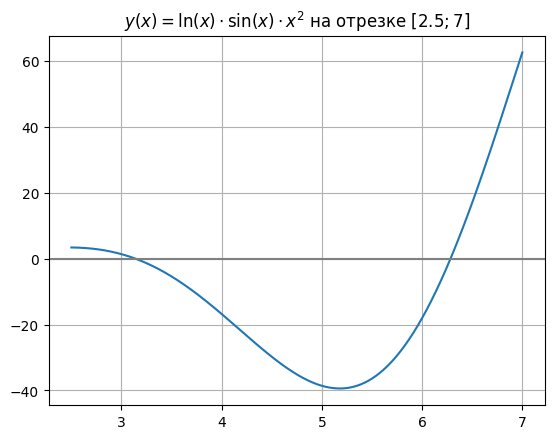

In [72]:
LEFT = 2.5
RIGHT = 7

plot(func, LEFT, RIGHT, "$y(x) = \ln(x) \cdot \sin(x) \cdot x^2$ на отрезке $[2.5; 7]$", y_axis=False)

Сделаем вспомогательный класс, который будет кэшировать значения функции

In [73]:
class FunctionCache:
    def __init__(self, func):
        self.func = func
        self.cache = {}

    def __call__(self, x):
        if x not in self.cache:
            self.cache[x] = self.func(x)
        return self.cache[x]
    
    def get_calls_amount(self):
        return len(self.cache)

## Реализация алгоритмов минимизации

### Метод дихотомии

In [74]:
def dichotomy(func: FunctionType, left, right, epsilon=1e-6, delta_func=lambda x, y: (y - x) / 4):
    iterations = 0
    segment_length = [right - left]
    while right - left > epsilon:
        middle = (left + right) / 2
        delta = delta_func(left, right)  # в нашей реализации delta = 1/4 отрезка
        x_1 = middle - delta
        x_2 = middle + delta
        if func(x_1) < func(x_2):
            right = x_2
        else:
            left = x_1
        iterations += 1
        segment_length.append(right - left)
    return {
        "value": (left + right) / 2,
        "iterations": iterations,
        "calls": iterations * 2,  # 2 вызова функции на каждой итерации
        "lengths": segment_length,
    }

### Метод золотого сечения

In [75]:
def golden_section(func: FunctionCache, left, right, epsilon=1e-6):
    iterations = 0
    segment_length = [right - left]
    while right - left > epsilon:
        delta = (right - left) / PHI
        x_1 = right - delta
        x_2 = left + delta

        if func(x_1) < func(x_2):
            right = x_2
        else:
            left = x_1
        iterations += 1
        segment_length.append(right - left)
    return {
        "value": (left + right) / 2,
        "iterations": iterations,
        "calls": func.get_calls_amount(),
        "lengths": segment_length,
    }

### Метод Фибоначчи

In [76]:
def fibonacci(func: FunctionCache, left, right, epsilon=1e-6):
    max_ = int((right - left) / epsilon)  # наибольшее требуемое число
    fib = [1, 1]
    while fib[-1] < max_:
        fib.append(fib[-1] + fib[-2])
  
    n = len(fib) - 1
    if n <= 2:
        return (left + right) / 2

    iterations = 0
    segment_length = [right - left]
    while n > 2:
        x_1 = left + fib[-3] / fib[-1] * (right - left)
        x_2 = left + fib[-2] / fib[-1] * (right - left)

        if func(x_1) < func(x_2):
            right = x_2
        else:
            left = x_1
        fib.pop()
        n -= 1
        iterations += 1
        segment_length.append(right - left)
    return {
        "value": (left + right) / 2,
        "iterations": iterations,
        "calls": func.get_calls_amount(),
        "lengths": segment_length,
    }

### Метод парабол

In [77]:
def parabola_minimum(f, x_1, x_2, x_3):
    return x_2 - ((x_2 - x_1) ** 2 * (f(x_2) - f(x_3)) - (x_2 - x_3) ** 2 * (f(x_2) - f(x_1))) / (2 * (x_2 - x_1) * (f(x_2) - f(x_3)) - (x_2 - x_3) * (f(x_2) - f(x_1)))

def parabolic(func: FunctionCache, left, right, epsilon=1e-6):
    x_2 = (left + right) / 2

    iterations = 0
    segment_length = [right - left]
    while right - left > epsilon:
        u = parabola_minimum(func, left, x_2, right)
        if func(x_2) < func(u):
            if x_2 < u:
                right = u
            else:
                left = u
            
        else:
            if x_2 < u:
                left = x_2
            else:
                right = x_2
            x_2 = u
        iterations += 1
        segment_length.append(right - left)
    return {
        "value": (left + right) / 2,
        "iterations": iterations,
        "calls": func.get_calls_amount(),
        "lengths": segment_length,
    }

### Комбинированный метод Брента
Реализация основна на псевдокоде из [лекции "Методы Оптимизации"](http://mathdep.ifmo.ru/wp-content/uploads/2020/09/lec_1_optimization.pdf)

In [78]:
def brent(func: FunctionCache, left, right, epsilon=1e-6):
    x = (left + right) / 2
    w = x  # предыдущее значение x или u
    v = x  # предпредыдущее значение x или u
    e = d = right - left  # удаление u от x

    iterations = 0
    segment_length = [right - left]
    while (right - left) > epsilon:
        g = e
        e = d
        accept = False
        if x != w and w != v and x != v and func(x) != func(w) and func(x) != func(v) and func(w) != func(v):
            u = parabola_minimum(func, x, w, v)
            if left + epsilon <= u <= right - epsilon and abs(u - x) < g / 2:
                accept = True
                d = abs(u - x)
        
        if not accept:
            if x < (left + right) / 2:
                delta = (right - x) / PHI
                u = right - delta  # золотое сечение [x, c]
                d = right - x
            else:
                delta = (x - left) / PHI
                u = left + delta  # золотое сечение [a, x]
                d = x - left
            
        if func(u) <= func(x):
            if u >= x:
                left = x
            else:
                right = x
            v = w
            w = x
            x = u
        else:
            if u >= x:
                right = u
            else:
                left = u
            if func(u) <= func(w):
                v = w
                w = u
            elif func(u) <= func(v) or v == x or v == w:
                v = u
        iterations += 1
        segment_length.append(right - left)
    return {
        "value": (left + right) / 2,
        "iterations": iterations,
        "calls": func.get_calls_amount(),
        "lengths": segment_length,
    }

### Решение задачи

In [79]:
print("Метод дихотомии:", dichotomy(func, LEFT, RIGHT, 0.01)["value"])
print("Метод золотого сечения:", golden_section(FunctionCache(func), LEFT, RIGHT, 0.01)["value"])
print("Метод Фибоначчи:", fibonacci(FunctionCache(func), LEFT, RIGHT, 0.01)["value"])
print("Метод парабол:", parabolic(FunctionCache(func), LEFT, RIGHT, 0.01)["value"])
print("Метод Брента:", brent(FunctionCache(func), LEFT, RIGHT, 0.01)["value"])

print("Ответ:", brent(FunctionCache(func), LEFT, RIGHT, 1e-10)["value"])

Метод дихотомии: 5.177655167547542
Метод золотого сечения: 5.181046284107217
Метод Фибоначчи: 5.1778688524590155
Метод парабол: 5.178905663478137
Метод Брента: 5.1791929569203905
Ответ: 5.17890565239635


## Сравнение методов

Получение результатов для $\varepsilon \in [0.001; 0.5]$

In [80]:
epsilons = np.linspace(0.001, 0.5, 100)

results = {
    "dichotomy": [dichotomy(func, LEFT, RIGHT, epsilon) for epsilon in epsilons],
    "golden section": [golden_section(FunctionCache(func), LEFT, RIGHT, epsilon) for epsilon in epsilons],
    "fibonacci": [fibonacci(FunctionCache(func), LEFT, RIGHT, epsilon) for epsilon in epsilons],
    "parabolic": [parabolic(FunctionCache(func), LEFT, RIGHT, epsilon) for epsilon in epsilons],
    "brent": [brent(FunctionCache(func), LEFT, RIGHT, epsilon) for epsilon in epsilons],
}

Сравнение количества итераций в зависимости от точности

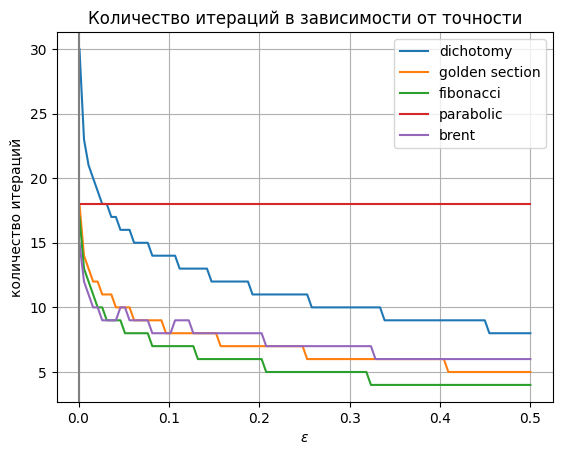

In [81]:
for method in results:
    plt.plot(epsilons, [result["iterations"] for result in results[method]], label=method)
plt.legend()
plt.grid()
plt.axvline(x=0, color="grey")
plt.title("Количество итераций в зависимости от точности")
plt.xlabel(r"$\varepsilon$")
plt.ylabel("количество итераций")
plt.show()


### Дополнительное сравнение: методы дихотомии
Рассмотрим методы дихотомии, которые по-разному определяют $\delta$

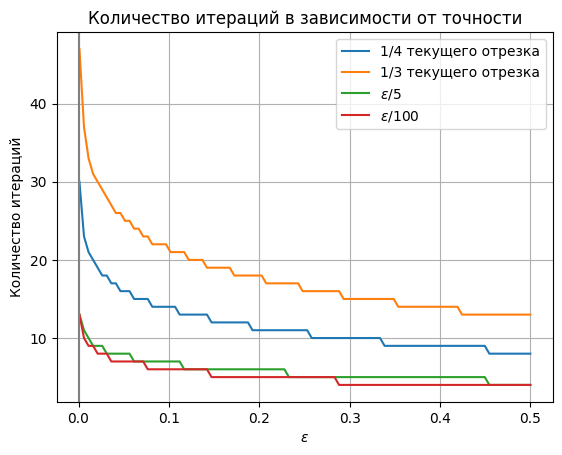

In [82]:
dichtomy_results = {
    "1/4 текущего отрезка": [dichotomy(func, LEFT, RIGHT, epsilon) for epsilon in epsilons],
    "1/3 текущего отрезка": [dichotomy(func, LEFT, RIGHT, epsilon, lambda x, y: (y - x) / 3) for epsilon in epsilons],
    r"$\varepsilon / 5$": [dichotomy(func, LEFT, RIGHT, epsilon, lambda x, y: epsilon / 5) for epsilon in epsilons],
    r"$\varepsilon / 100$": [dichotomy(func, LEFT, RIGHT, epsilon, lambda x, y: epsilon / 100) for epsilon in epsilons],
}
for dichtomy_result in dichtomy_results:
    plt.plot(epsilons, [result["iterations"] for result in dichtomy_results[dichtomy_result]], label=dichtomy_result)
plt.legend()
plt.grid()
plt.axvline(x=0, color="grey")
plt.title("Количество итераций в зависимости от точности")
plt.xlabel(r"$\varepsilon$")
plt.ylabel("Количество итераций")
plt.show()

### Дополнительное сравнение: методы парабол
Рассмотрим методы парабол на разных функциях

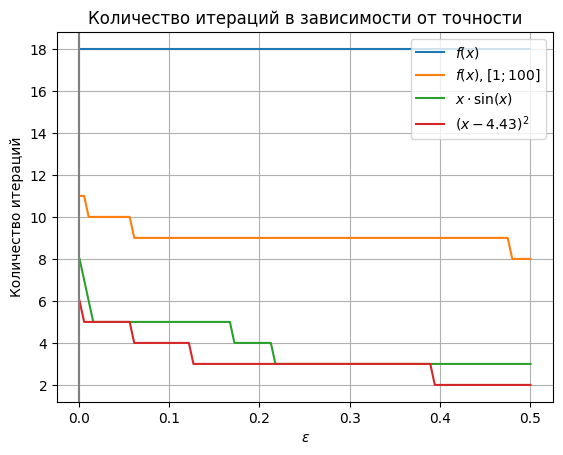

In [83]:
parabola_results = {
    "$f(x)$": [parabolic(FunctionCache(func), LEFT, RIGHT, epsilon) for epsilon in epsilons],
    "$f(x), [1; 100]$": [parabolic(FunctionCache(func), 1, 100, epsilon) for epsilon in epsilons],
    "$x \cdot \sin(x)$": [parabolic(FunctionCache(lambda x: np.sin(x) * x), LEFT, RIGHT, epsilon) for epsilon in epsilons],
    "$(x - 4.43)^2$": [parabolic(FunctionCache(lambda x: (x - 4.43) ** 2), LEFT, RIGHT, epsilon) for epsilon in epsilons],
}
for parabola_result in parabola_results:
    plt.plot(epsilons, [result["iterations"] for result in parabola_results[parabola_result]], label=parabola_result)
plt.legend()
plt.grid()
plt.axvline(x=0, color="grey")
plt.title("Количество итераций в зависимости от точности")
plt.xlabel(r"$\varepsilon$")
plt.ylabel("Количество итераций")
plt.show()

Сравнение количества вычислений функции в зависимости от точности

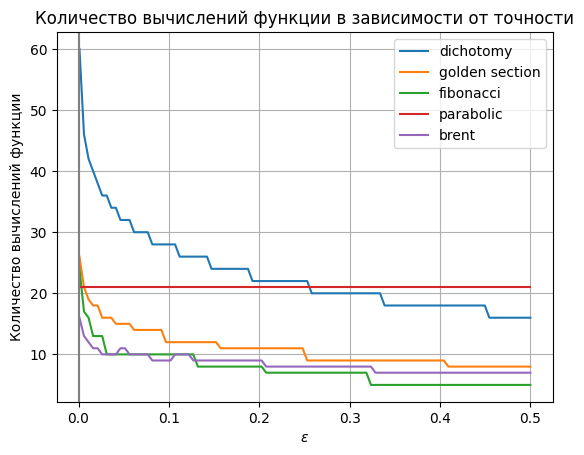

In [84]:
for method in results:
    plt.plot(epsilons, [result["calls"] for result in results[method]], label=method)
plt.legend()
plt.grid()
plt.axvline(x=0, color="grey")
plt.title("Количество вычислений функции в зависимости от точности")
plt.xlabel(r"$\varepsilon$")
plt.ylabel("Количество вычислений функции")
plt.show()

Размер отрезка в зависимости от номера итерации

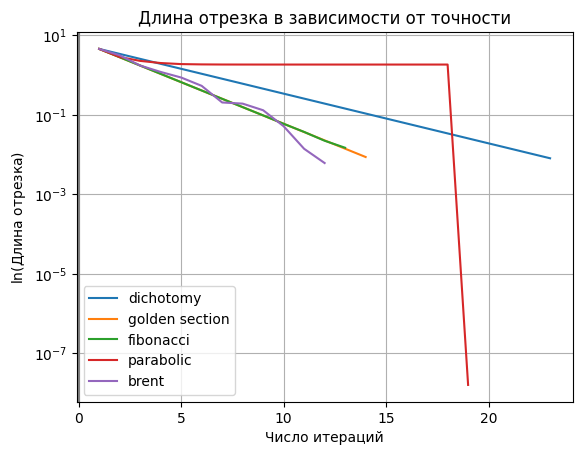

In [85]:
results = {
    "dichotomy": dichotomy(func, LEFT, RIGHT, 0.01),
    "golden section": golden_section(FunctionCache(func), LEFT, RIGHT, 0.01),
    "fibonacci": fibonacci(FunctionCache(func), LEFT, RIGHT, 0.01),
    "parabolic": parabolic(FunctionCache(func), LEFT, RIGHT, 0.01),
    "brent": brent(FunctionCache(func), LEFT, RIGHT, 0.01),
}

for method in results:
    plt.plot(list(range(1, len(results[method]["lengths"]) + 1)), results[method]["lengths"], label=method)
plt.yscale("log")
plt.legend()
plt.grid()
plt.axvline(x=0, color="grey")
plt.title("Длина отрезка в зависимости от точности")
plt.xlabel("Число итераций")
plt.ylabel(r"$\ln($Длина отрезка$)$")
plt.show()

Рассмотрим суперлинейную сходимость метода парабол более подробно

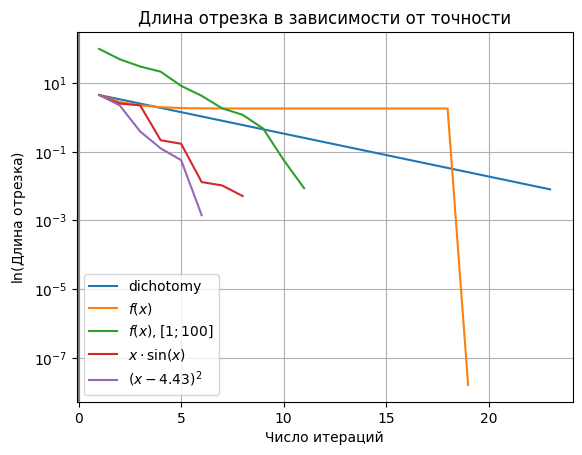

In [86]:
results = {
    "dichotomy": dichotomy(func, LEFT, RIGHT, 0.01),
    "$f(x)$": parabolic(FunctionCache(func), LEFT, RIGHT, 0.01),
    "$f(x), [1; 100]$": parabolic(FunctionCache(func), 1, 100, 0.01),
    "$x \cdot \sin(x)$": parabolic(FunctionCache(lambda x: np.sin(x) * x), LEFT, RIGHT, 0.01),
    "$(x - 4.43)^2$": parabolic(FunctionCache(lambda x: (x - 4.43) ** 2), LEFT, RIGHT, 0.01),
}

for method in results:
    plt.plot(list(range(1, len(results[method]["lengths"]) + 1)), results[method]["lengths"], label=method)
plt.yscale("log")
plt.legend()
plt.grid()
plt.axvline(x=0, color="grey")
plt.title("Длина отрезка в зависимости от точности")
plt.xlabel("Число итераций")
plt.ylabel(r"$\ln($Длина отрезка$)$")
plt.show()

## Минимизация многомодальных функций

Исходная функция на отрезке $[1; 20]$

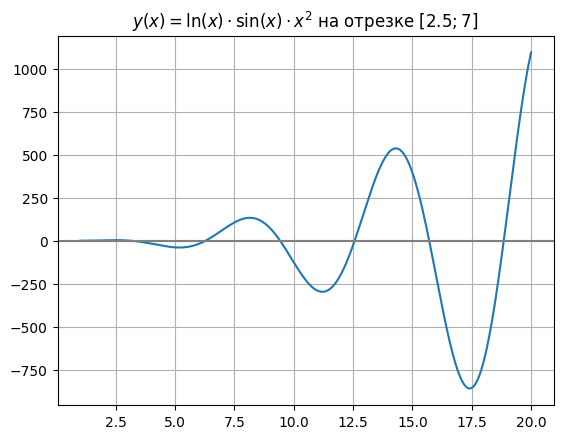

Метод дихотомии: 11.207732973355204
Метод золотого сечения: 11.207601601817819
Метод Фибоначчи: 11.207767735631784
Метод парабол: 11.207747369994667
Метод Брента: 11.207725105475003


In [87]:
plot(func, 1, 20, "$y(x) = \ln(x) \cdot \sin(x) \cdot x^2$ на отрезке $[2.5; 7]$", y_axis=False)

print("Метод дихотомии:", dichotomy(func, 1, 20, 0.001)["value"])
print("Метод золотого сечения:", golden_section(FunctionCache(func), 1, 20, 0.001)["value"])
print("Метод Фибоначчи:", fibonacci(FunctionCache(func), 1, 20, 0.001)["value"])
print("Метод парабол:", parabolic(FunctionCache(func), 1, 20, 0.001)["value"])
print("Метод Брента:", brent(FunctionCache(func), 1, 20, 0.001)["value"])

Функция $f_1(x)$ на отрезке $[0; 10]$

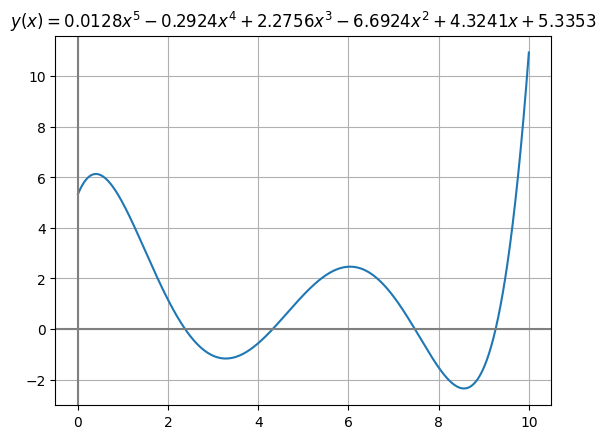

Метод дихотомии: 3.2789924620315114
Метод золотого сечения: 3.2791031987336696
Метод Фибоначчи: 3.2788233144527688
Метод парабол: 3.2786611898181732
Метод Брента: 3.278871843148635


In [88]:
def func_1(x):
    return 0.0128 * x ** 5 - 0.2924 * x ** 4 + 2.2756 * x ** 3 - 6.6924 * x ** 2 + 4.3241 * x + 5.3353

plot(func_1, 0, 10, "$y(x) = 0.0128x^5 - 0.2924x^4 + 2.2756x^3 - 6.6924x^2 + 4.3241x + 5.3353$")

print("Метод дихотомии:", dichotomy(func_1, 0, 10, 0.001)["value"])
print("Метод золотого сечения:", golden_section(FunctionCache(func_1), 0, 10, 0.001)["value"])
print("Метод Фибоначчи:", fibonacci(FunctionCache(func_1), 0, 10, 0.001)["value"])
print("Метод парабол:", parabolic(FunctionCache(func_1), 0, 10, 0.001)["value"])
print("Метод Брента:", brent(FunctionCache(func_1), 0, 10, 0.001)["value"])

Функция $f_2(x)$ на отрезке $[1; 7]$

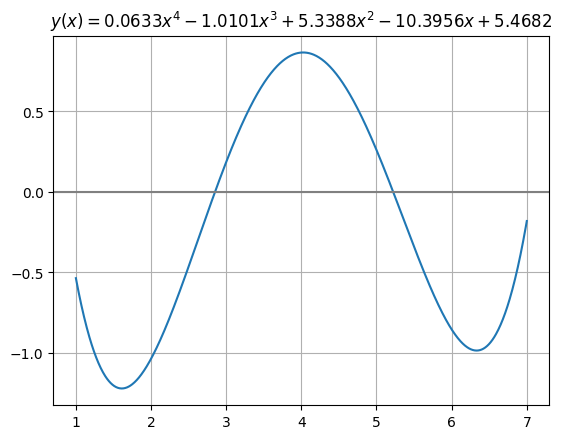

Метод дихотомии: 1.6110191812771233
Метод золотого сечения: 1.6110799664080753
Метод Фибоначчи: 1.6110864745011089
Метод парабол: 3.6213652185179455
Метод Брента: 1.6110111016023154


In [89]:
def func_2(x):
    return  0.0633 * x ** 4 - 1.0101 * x ** 3 + 5.3388 * x ** 2 - 10.3956 * x + 5.4682

plot(func_2, 1, 7, "$y(x) = 0.0633x^4 - 1.0101x^3 + 5.3388x^2 - 10.3956x + 5.4682$", y_axis=False)

print("Метод дихотомии:", dichotomy(func_2, 1, 7, 0.001)["value"])
print("Метод золотого сечения:", golden_section(FunctionCache(func_2), 1, 7, 0.001)["value"])
print("Метод Фибоначчи:", fibonacci(FunctionCache(func_2), 1, 7, 0.001)["value"])
print("Метод парабол:", parabolic(FunctionCache(func_2), 1, 7, 0.001)["value"])
print("Метод Брента:", brent(FunctionCache(func_2), 1, 7, 0.001)["value"])